In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/mnt/ssd-1/spar/waree/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
num_hidden_layers = 40
layers_arr = np.arange(num_hidden_layers)

So in code I would take each weight like v1 = lr_reporter.linear.weight  or something and v2 = vinc_reporter.weight, and then v1 /= np.linalg.norm(v1), v2 /= np.linalg.norm(v2) and finally cosine_sim = v1.T @ v2

In [4]:
def load_and_stack_layers(num_layers: int, prefix_path: str) -> torch.Tensor:
    layers = []
    for i in range(num_layers):
        layer_path = f"{prefix_path}/layer_{i}.pt"
        layer = torch.load(layer_path)
        layers.append(layer.weight.cpu())
    stacked = torch.cat(layers, dim=0)
    return stacked

In [12]:
def similarity(reporter1_path: str, reporter2_path: str):
    rep1_weights = load_and_stack_layers(num_hidden_layers,path1)
    rep2_weights = load_and_stack_layers(num_hidden_layers,path2)
    rep1_magnitude = torch.norm(rep1_weights, dim=-1, keepdim=True)
    rep2_magnitude = torch.norm(rep2_weights, dim=-1, keepdim=True)
    rep1_normalized = rep1_weights/rep1_magnitude
    rep2_normalized = rep2_weights/rep2_magnitude
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim
    

In [18]:
path1 = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_0/llama13b-imdb0/reporters'
#path2 = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_0/llama13b-imdb0/lr_models'
path2 = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_5/sleepy-mirzakhani/reporters'

In [5]:
path = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_0/nervous-franklin/reporters'
stack = load_and_stack_layers(num_hidden_layers, path)

In [8]:
path2 = '/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_0/nervous-franklin/lr_models'
stack2 = load_and_stack_layers(num_hidden_layers, path2)

AttributeError: 'Classifier' object has no attribute 'weight'

In [11]:
loaded = torch.load('/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_0/nervous-franklin/lr_models/layer_1.pt')

In [21]:
loaded

Classifier(
  (linear): Linear(in_features=5120, out_features=1, bias=True)
)

RuntimeError: Invalid magic number; corrupt file?

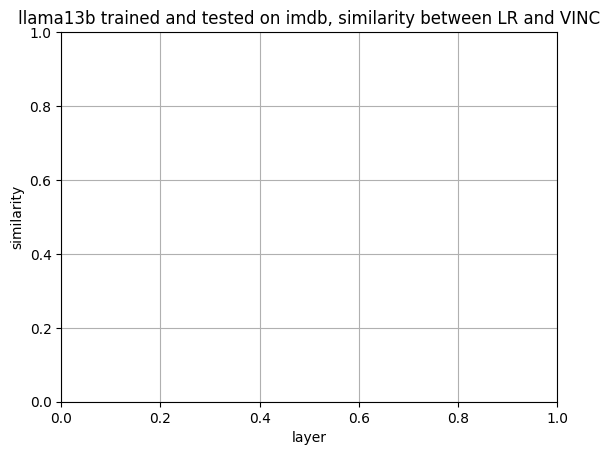

In [22]:
model = 'llama13b'

fig, ax = plt.subplots()
ax.set_title(fr"{model} trained and tested on imdb, similarity between LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

# Set line colors and styles
# line_colors = ['black', 'blue', 'red', 'green', 'orange','purple', 'teal', 'pink', 'sage', 'grey']
# ccs_line_style = '--'
# lr_line_style = ':'
# zs_line_style = '-.'

sim = similarity(path1, path2)
    
ax.plot(layers_arr,sim)

# experiment = data[(model, train_dataset, test_dataset, 'ccs')]
# layers = experiment['layer']
# acc = experiment['acc']
# ax.plot(layers, acc, label=f'CCS tested on {test_dataset}',
#             color=line_color, linestyle=ccs_line_style)

# if 'lm_acc' in experiment.columns:
#     lm_acc = experiment['lm_acc']
#     # Set line color and style for zero-shot dataset
#     ax.plot(layers, lm_acc, label='zero-shot language model output',
#             color=line_color, linestyle=zs_line_style)

# if 'lr_acc' in experiment.columns:
#     lr_acc = experiment['lr_acc']
#     # Set line color and style for logistic regression dataset
#     ax.plot(layers, lr_acc, label='logistic regression',
#             color=line_color, linestyle=lr_line_style)
                
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()